# This code checks the lag of the raw data, both pressure and force

# read dynamic force

In [2]:
# Set the font family to Times New Roman
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 12

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from scipy.signal import filtfilt
from scipy.signal import bessel
b, a = bessel(8, 0.01) # define the bessel filter; 8 is the filter order; 0.01 is the W_n (between 0 to 1)

In [20]:
Case       = ['A','B','C','D','E','F']
num_files  = 10    # number of runs for each case; they should have the same runs for post-process
nMotionStart = 17420 # motion starts at this index/instant

In [9]:
force_raw    = {} # initialize a dictionary, with keys and values

# import data
for k in Case: # loop to read all the six cases
    Folder = './inputs/experiments/Case' + k + '/' # where files are stored
    print(Folder)
    for i in range(num_files): # loop to read all the twn individual runs
        # Import the force data:
        fileName = 'Force_Data_Run_' + f'{i+1:02d}' + '.csv'
        force_raw[k,i] = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=[2,4,7], names= ["fx","fy","mz"])
        force_raw[k,i] = force_raw[k,i].to_numpy()
        # transform data to numpy array

./inputs/experiments/CaseA/
./inputs/experiments/CaseB/
./inputs/experiments/CaseC/
./inputs/experiments/CaseD/
./inputs/experiments/CaseE/
./inputs/experiments/CaseF/


## plot eqach case
**check the lag**

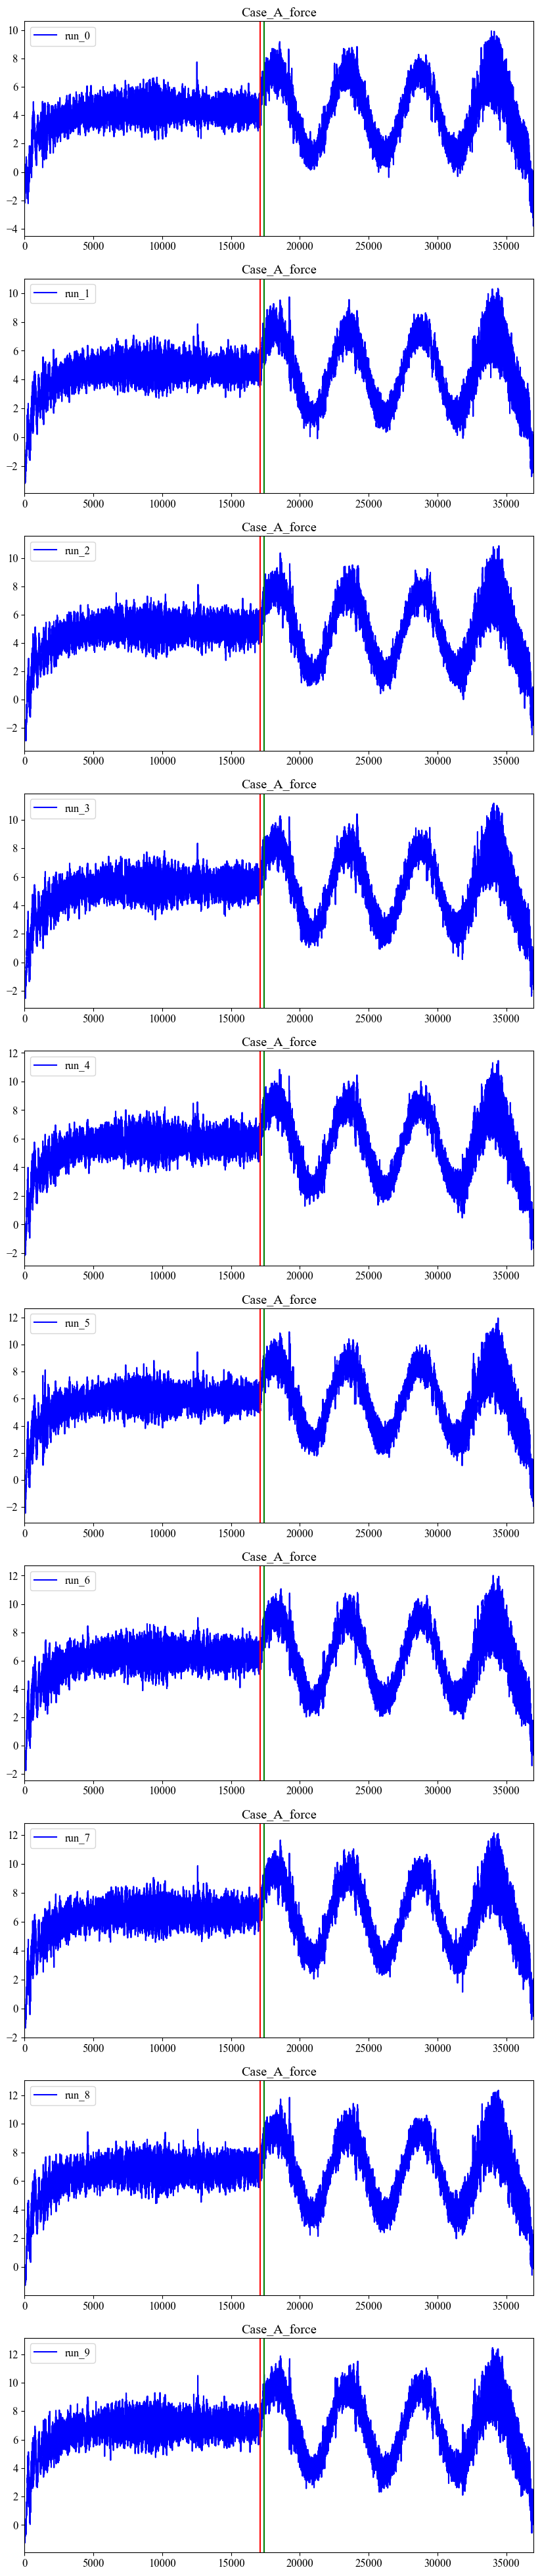

In [124]:
num_runs = 10 # 10 runs for each case
case_show = 'A'
fig,ax=plt.subplots(num_runs,1,figsize=(10,5*num_runs))
for i in range(num_runs):
    x = np.linspace(0,total_len,total_len)
    y = force_raw[(case_show, i)][0:total_len,1]
    
    ax[i].plot(x,y, 'b', label=f'run_{i}')
    ax[i].set_xmargin(0)
    ax[i].legend()
    ax[i].set_title('Case_'+case_show+'_'+'force')
    
    ax[i].axvline(x=17100, color='r')
    ax[i].axvline(x=nMotionStart, color='g')
    # ax[i].set_xlim([15000,20000])

# read dynamic pressure

In [69]:
# First 10 pressure ports 
p_raw_10  = {} # initialize a dictionary, with keys and values
p_raw_5   = {} # initialize a dictionary, with keys and values
p_raw = {}
p_raw_filt = {}
total_len = 37000

Columns10 = [2,3,4,5,6,7,8,9,10,11]
Names10   = ['p1','p2','p3','p4','p5','p6','p7','p8','p9','p10']
nports1   = 10

Columns5  = [3,4,5,6,7]
Names5    = ['p15','p14','p13','p12','p11']
nports2   = 5

for k in Case:
    # First 10 pressure ports 
    Folder = './inputs/experiments/Case' + k + '/'
    print(Folder)

    for i in range(num_runs):
        fileName = 'Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        p_raw_10[k,i] = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns10, names=Names10)
        p_raw_10[k,i] = p_raw_10[k,i].to_numpy()
        
    # Last 5 pressure ports
    for i in range(num_runs): 
        fileName   = 'extra_pressure_ports/Pressure_Data_Run_' + f'{i+1:02d}' + '.csv'
        p_raw_5[k,i] = pd.read_csv(Folder+fileName, skiprows=1, sep=',', usecols=Columns5, names=Names5)
        p_raw_5[k,i] = p_raw_5[k,i].to_numpy()
        
    # combine the first 10 and last 5 pressure taps
    for i in range(num_runs):
        p_raw[k,i] = np.concatenate((p_raw_10[k,i][0:total_len,:], p_raw_5[k,i][0:total_len,:]), axis=1)
        p_raw_filt[k,i] = np.empty_like(p_raw[k,i])
        
        # filter data
        for j in range(15):
            p_raw_filt[k,i][:,j] = filtfilt(b, a, p_raw[k,i][:,j])
        
print('Done!')

./inputs/experiments/CaseA/
./inputs/experiments/CaseB/
./inputs/experiments/CaseC/
./inputs/experiments/CaseD/
./inputs/experiments/CaseE/
./inputs/experiments/CaseF/
Done!


## plot eqach case
**check the lag**

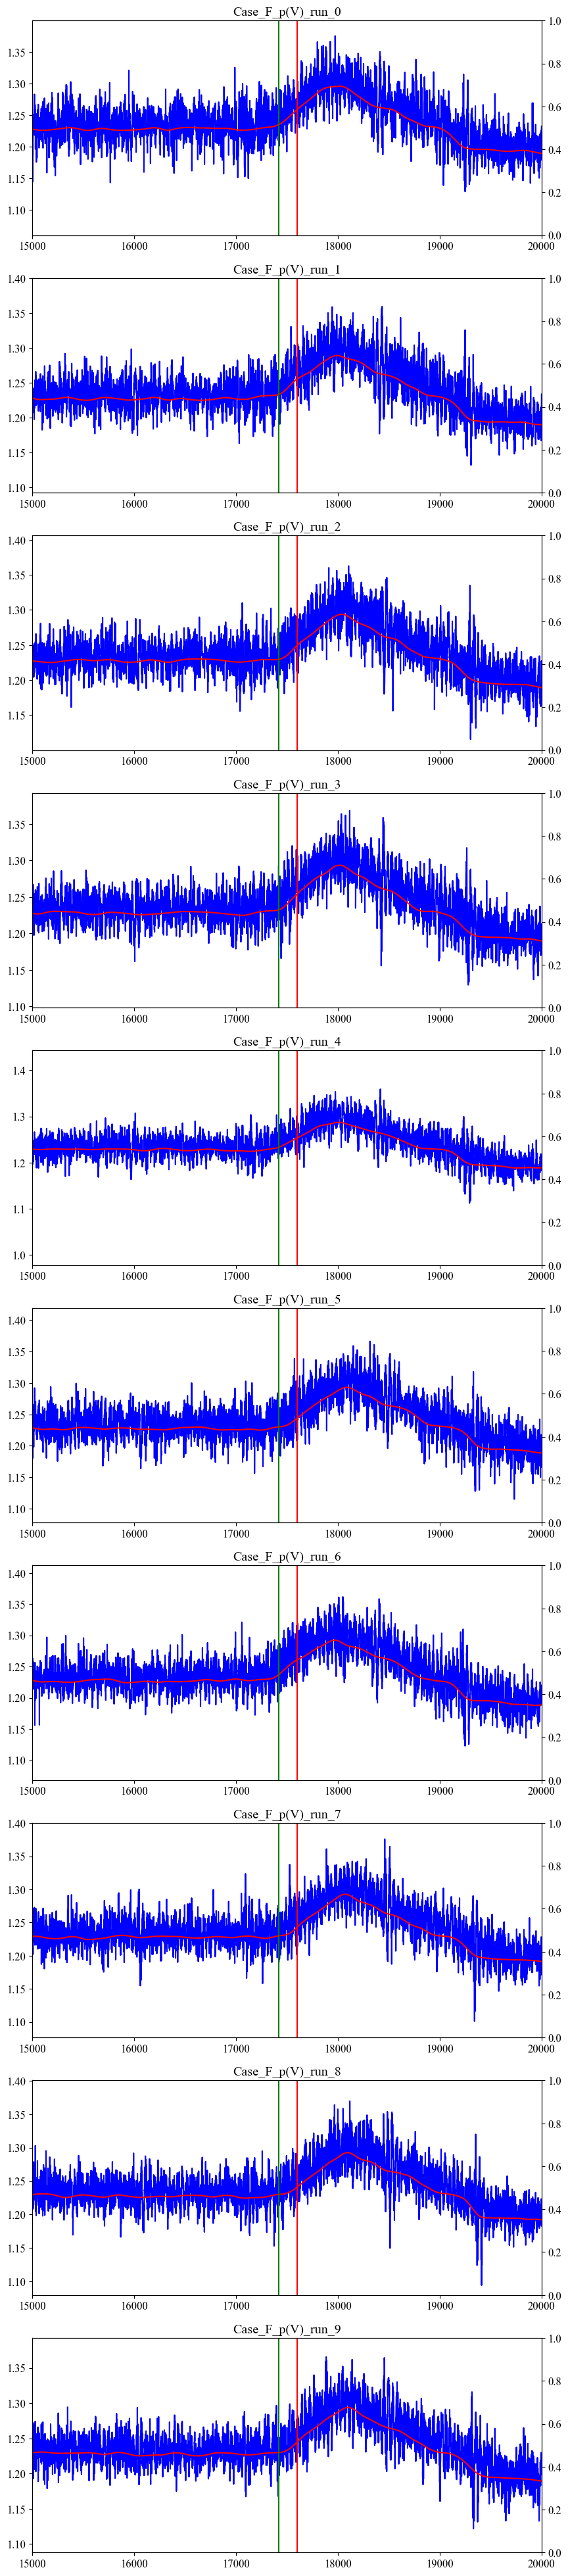

In [106]:
case_show = 'F'
fig,ax = plt.subplots(num_runs,1,figsize=(10,5*num_runs))
for i in range(num_runs):
    x = np.linspace(0,total_len,total_len)
    y = p_raw_filt[case_show, i][:,0]
    
    ax1 = ax[i]
    ax1.plot(x, p_raw[case_show, i][:,0], 'b', label=f'run_{i}')
    ax1.plot(x, y, 'r', label=f'run_{i}')
    ax1.axvline(x=17600, color='r')
    ax1.axvline(x=nMotionStart, color='g')
    ax1.set_xmargin(0)
    ax1.set_title('Case_'+case_show+'_p(V)_'+f'run_{i}')
    
    # Calculate the forward difference of y
    ax2 = ax1.twinx()
    dydx = np.diff(y) / np.diff(x)
    # ax2.plot(x[1:], dydx, 'g')
    
    ax[i].set_xlim([15000,20000])

# Define the AOA

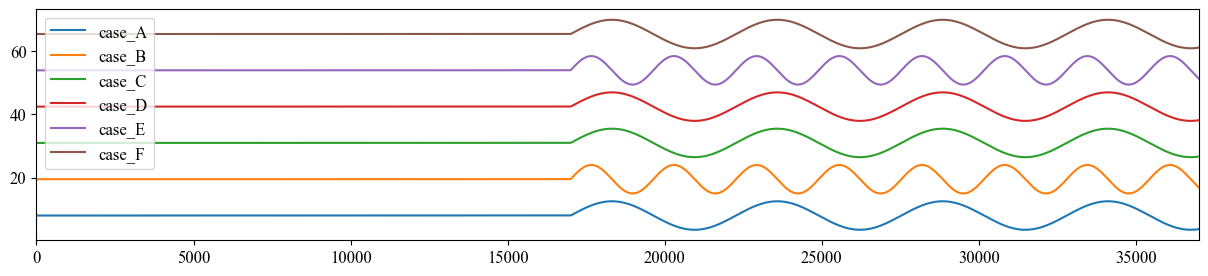

In [167]:
nt     = 190   # length of data
Period       = 37 #s, time-interval of analysis
len_period   = int((1/0.19)*1000)-1 # =5262, -1 is useful for later calculation; length of one period; samples number

nDataPoints  = total_len # total number of data points; three periods can be used
RefFreq    = np.array([0.19, 0.38, 0.19, 0.19, 0.38, 0.19])  # reference frequency, for normalization
dAlpha     = 4.5   # change in AoA: p-to-p, deg

# Define AoA:
# Create real-motion profile:
MotionTime = np.linspace(0,Period,total_len)
Alpha0 = 8.0   # mean AoA, deg
Omega  = 2*np.pi*RefFreq
AoA    = np.zeros((nDataPoints,6))
movTime = MotionTime[17000:nDataPoints] - MotionTime[17000]
for i in range(6):
    AoA[0:17000,i] = Alpha0*np.pi/180    # AoA(t<t0) = Alpha0, before pitching or plunging
    AoA[17000:nDataPoints,i]  = ( Alpha0 + dAlpha*np.sin( Omega[i]*(movTime) ) )*np.pi/180
    
fig,ax = plt.subplots(figsize=(15,3))
for i in range(6):
    ax.plot((AoA[:,i]+0.2*i)*180/np.pi, label='case_'+Case[i]) # add +0.2*i to distinguish them
    ax.set_xmargin(0)
ax.legend(loc='upper left')

**compare the aoas and force**

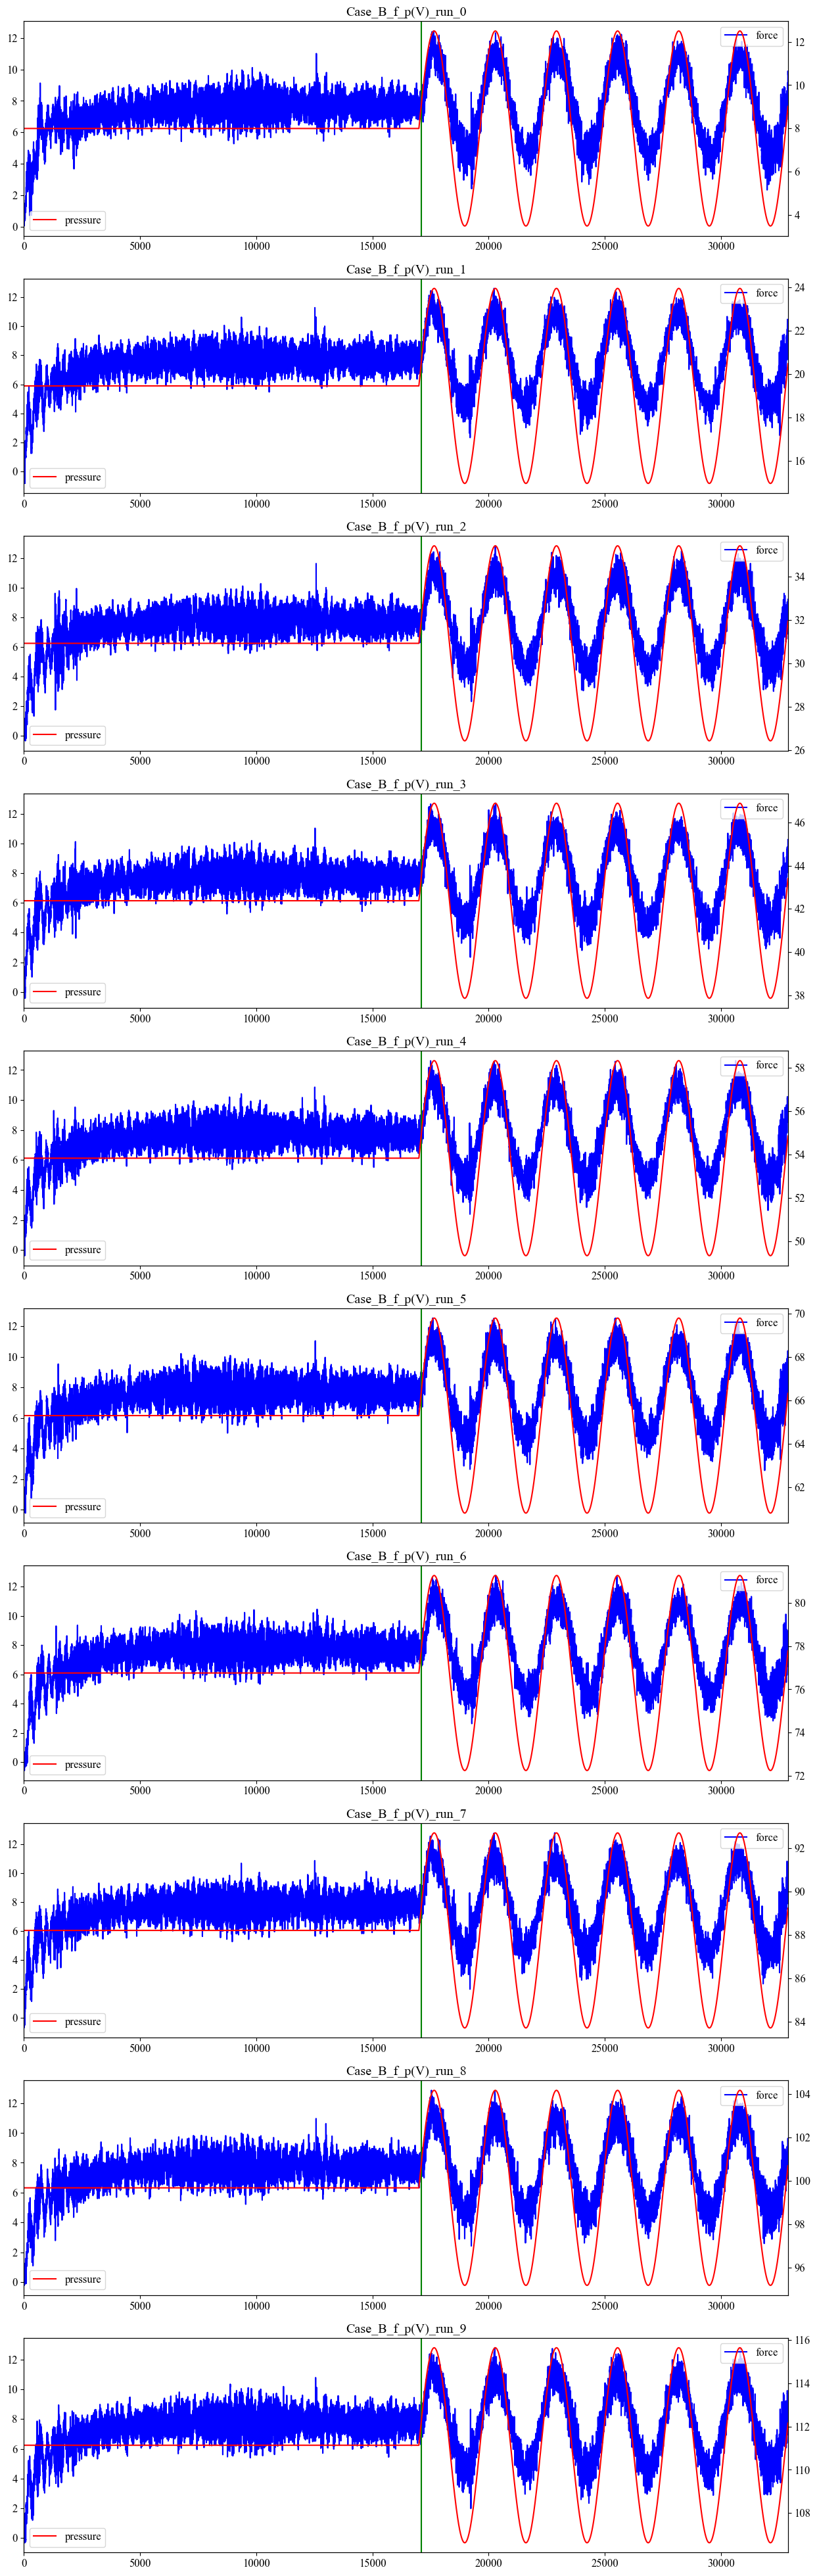

In [183]:
total_len = 17100+5262*3
case_show = 'B'
fig,ax = plt.subplots(num_runs,1,figsize=(15,5*num_runs))
for i in range(num_runs):
    x = np.linspace(0,total_len,total_len)
    y1 = force_raw[(case_show, i)][0:total_len,1]
    if case_show in ['A','C','D','F']:
        y2 = (AoA[0:total_len,0]+0.2*i)*180/np.pi
    else:
        y2 = (AoA[0:total_len,1]+0.2*i)*180/np.pi
    
    ax1 = ax[i]
    ax1.plot(x, y1, 'b', label='force')
    ax1.set_xmargin(0)
    
    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'r', label='pressure')
    
    ax1.set_title('Case_'+case_show+'_f_p(V)_'+f'run_{i}')
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower left')
    
    ax1.axvline(x=17100, color='g')

# Compare force and pressure

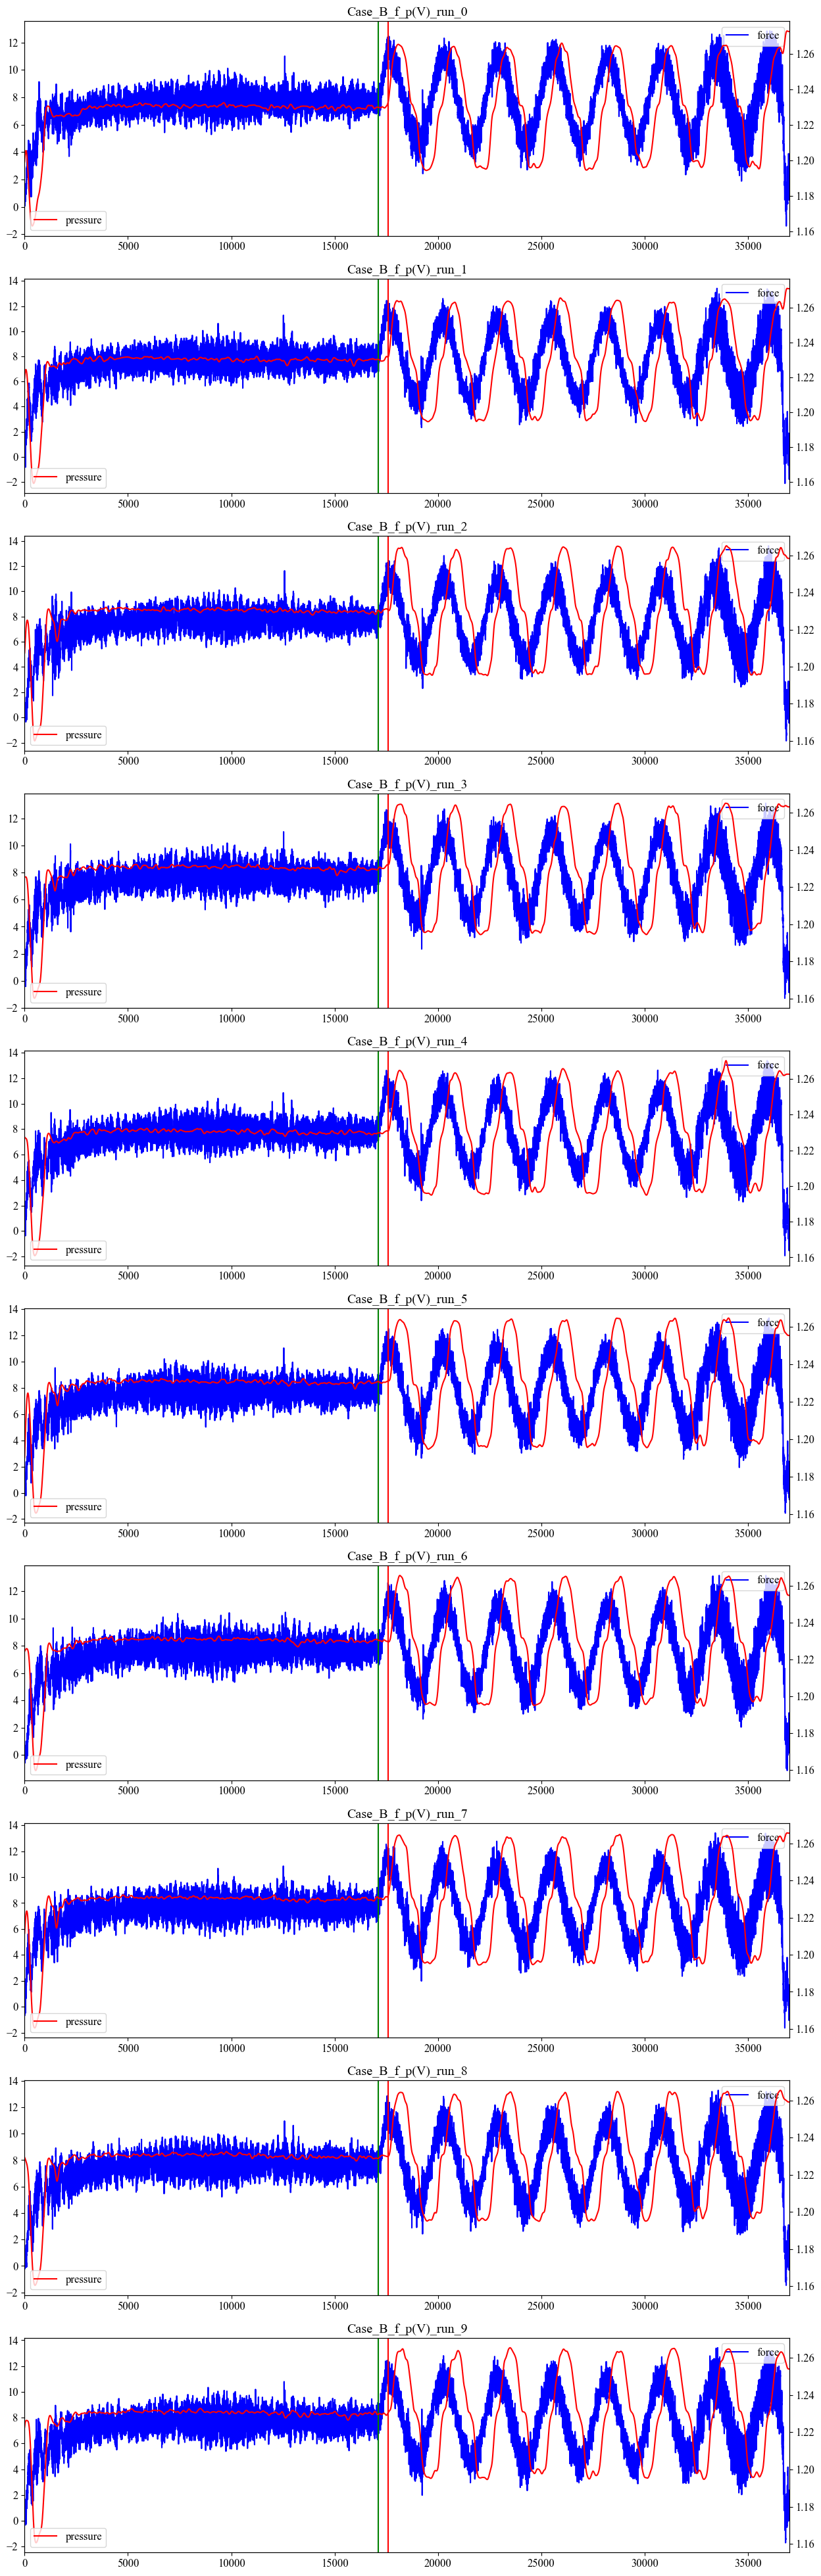

In [179]:
case_show = 'B'
fig,ax = plt.subplots(num_runs,1,figsize=(15,5*num_runs))
for i in range(num_runs):
    x = np.linspace(0,total_len,total_len)
    y1 = force_raw[(case_show, i)][0:total_len,1]
    y2 = p_raw_filt[case_show, i][:,0]
    
    ax1 = ax[i]
    ax1.plot(x, y1, 'b', label='force')
    ax1.set_xmargin(0)
    
    ax2 = ax1.twinx()
    ax2.plot(x, y2, 'r', label='pressure')
    
    ax1.set_title('Case_'+case_show+'_f_p(V)_'+f'run_{i}')
    
    ax1.legend(loc='upper right')
    ax2.legend(loc='lower left')
    
    ax1.axvline(x=17100, color='g')
    if case_show in ['A','B','C']:
        ax1.axvline(x=17600, color='r')
    else:
        ax1.axvline(x=17300, color='r')